In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm.notebook import tqdm

from IPython.core.debugger import set_trace

In [2]:
def get_dataloader(batch_size):
    transforms = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5), (0.5))
    ])

    dataset = MNIST("./data", download=True, transform=transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def sample_noise(latent_len, batch_size):
    out = []
    for i in range(batch_size):
        out.append(torch.normal(mean=torch.zeros(latent_len) + 0.5, std=torch.ones(latent_len) - 0.5))
    return torch.stack(out)

In [25]:
def discriminator_loss(pred, target):
    criterion = nn.BCELoss()
    loss = criterion(pred.flatten(), target)
    return loss

# def generator_loss(pred):
#     return torch.log(1 - pred.flatten())

def generator_loss(pred):
    criterion = nn.BCELoss()
    loss = criterion(pred.flatten(), torch.zeros(pred.flatten().shape))
    return loss

In [26]:
# def discriminator_loss(pred, target):
#     criterion = nn.BCELoss()
#     loss = criterion(pred.reshape(*pred.shape[:-1]), target)
#     return loss

# def generator_loss(pred):
#     return torch.log(1 - pred)

In [27]:
generator_loss(torch.Tensor([0]))

tensor(0.)

In [28]:
generator_loss(torch.Tensor([1]))

tensor(100.)

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_len):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(in_features=latent_len, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=28*28)
        
    def forward(self, z):
        z = self.fc1(z).relu()
        z = self.fc2(z)
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=100)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).sigmoid()
        return x

In [30]:
def train_gan(hp):
    
    ## Models
    G = Generator(hp["latent_len"])
    D = Discriminator()
    
    # Optimizer
    optimizer_G = optim.Adam(G.parameters(), lr=hp["lr"])
    optimizer_D = optim.Adam(D.parameters(), lr=hp["lr"])
    
    # Data
    data_loader = get_dataloader(hp["batch_size"])
    
    # Train
    for epoch in range(hp["epochs"]):
        print("\n#### Epoch ", epoch + 1)
        running_loss_D = []
        running_loss_G = []
        
        for batch in tqdm(data_loader):
            # Minibatch
            x, _ = batch
        
            #########################
            ## Train Discriminator ##
            #########################
            
            ## Prep
            D.train(); G.eval();
            z = sample_noise(latent_len=hp["latent_len"], batch_size=hp["batch_size"])
            gen = G(z)
            
            ## Pred
            batch = torch.cat([x.reshape([hp["batch_size"], 28*28]), gen])
            targets = torch.cat([torch.ones(hp["batch_size"]), torch.zeros(hp["batch_size"])])
            
            ## Loss
            preds = D(batch)
            loss_D = torch.mean(discriminator_loss(preds, targets) - generator_loss(preds))
            running_loss_D.append(loss_D.item())
            
            # Backprop
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            #####################
            ## Train Generator ##
            #####################
            
            ## Prep
            D.eval(); G.train();
            z = sample_noise(latent_len=hp["latent_len"], batch_size=hp["batch_size"])
            
            ## Pred
            gen = G(z)
            preds = D(gen)
            
            ## Loss
            loss_G = torch.mean(generator_loss(preds))
            running_loss_G.append(loss_G.item())
            
            # Backprop
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
        
        print("Loss_D:", np.mean(running_loss_D))
        print("Loss_G:", np.mean(running_loss_G))
        
    torch.save(G.state_dict(), "checkpoints/generator.pt")
    torch.save(D.state_dict(), "checkpoints/discriminator.pt")

In [31]:
def visualize_output(hp):  
    # Sample noise vector z
    z = sample_noise(hp["latent_len"], 32)
    
    # Load trained generator
    G = Generator(hp["latent_len"])
    G.load_state_dict(torch.load("checkpoints/generator.pt"))
    
    # Generate image
    sample = G(z)
    output = sample.detach().numpy()

    # Display
    fig=plt.figure(figsize=(20, 8))
    columns = 8
    rows = 4
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(output[i-1, :].reshape([28,28]))
    plt.show()

In [32]:
hp = {
    "epochs": 5,
    "latent_len": 20,
    "batch_size": 32,
    "lr": 3e-4
}

In [33]:
train_gan(hp)


#### Epoch  1



Loss_D: -49.127991165796914
Loss_G: 0.013251096538530934

#### Epoch  2



Loss_D: -49.99928954467774
Loss_G: 8.546756423459101e-06

#### Epoch  3



Loss_D: -49.99929940999349
Loss_G: 2.4531223610921415e-06

#### Epoch  4



Loss_D: -49.999999979654945
Loss_G: 6.536235721524027e-07

#### Epoch  5



Loss_D: -49.999999991861976
Loss_G: 3.303450443669457e-07


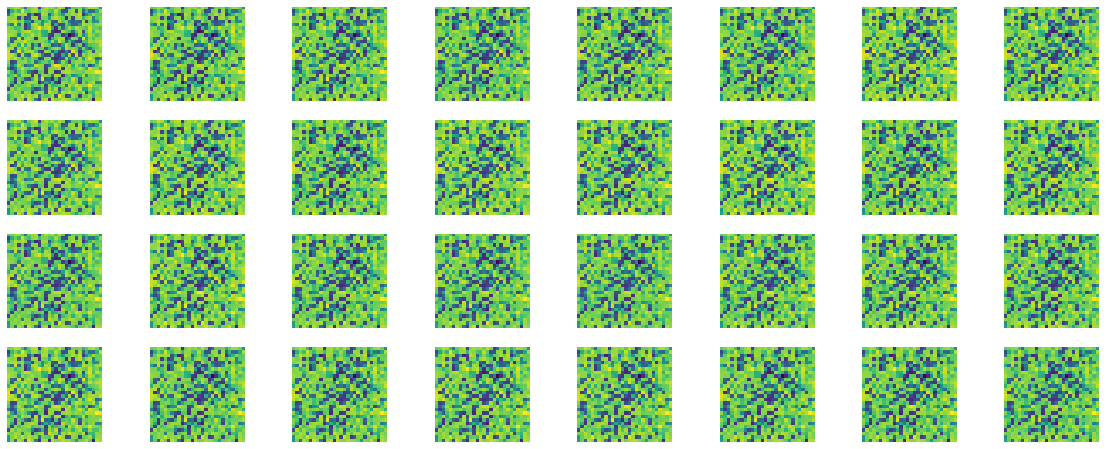

In [34]:
visualize_output(hp)